In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/CV_FinalProject/Dungmn/
print("===============")
!ls 

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1rvVQN848IG4yYS2DU7AHiKiDnungjDoK/CV_FinalProject/Dungmn
 attention_tf
 attention_tf_resnet
 coco
 coco-caption
'Copy of Copy of image_captioning UIT-ViIC.ipynb'
 correct_captions_val.csv
 Data
 eval.ipynb
 Image_Captioning_PhoBert.ipynb
 image_captioning_pytorch
 Image-Captions
 preprocessing.ipynb
 pytorch-tutorial
 Resnet101_Attention_LSTM.ipynb
 Resnet512_LSTM.ipynb
 result
 show_attend_and_tell_pytorch
 test.csv
 train_UITViIC.csv
 train_UITViIC_raw.csv.gsheet
 transformers


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

!pip install underthesea
from underthesea import word_tokenize

from tqdm import tqdm

##Load Dataset

In [ ]:
!ls Data/UIT-ViIC

checkpoint	      preprocessed_uitviic_captions_test2017.json
npy		      test_imgs
pickles		      train_val_combined
pickles_resnet152     train_val_combined.json
predict_on_test_data  train_val_combined_OLD.json


In [ ]:
annotation_file = "Data/UIT-ViIC/train_val_combined.json"
PATH = "Data/UIT-ViIC/train_val_combined/"

3612
<start> Đứa trẻ đeo găng_tay bóng chày đang cầm quả bóng chày . <end>


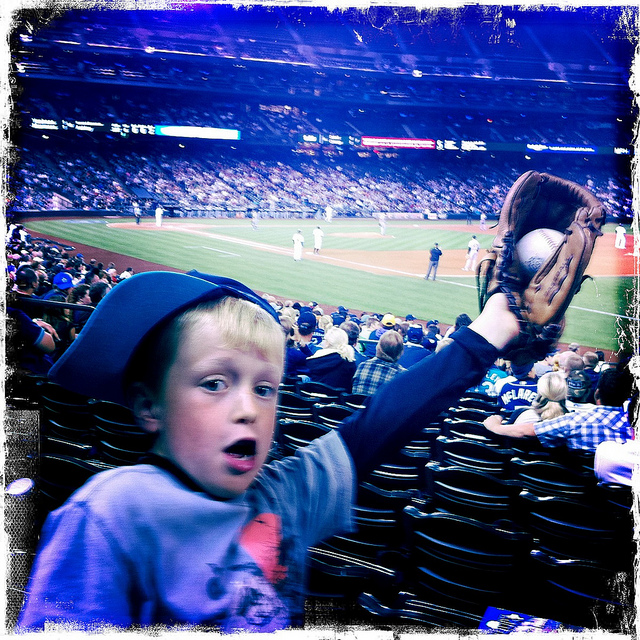

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

def preprocess_for_vietnamese(sentence):
    # cap_segment = ViTokenizer.tokenize(sentence)
    cap_segment = word_tokenize(sentence, format="text")
    return cap_segment

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  # caption = f"<start> {val['caption']} <end>"
  # print(preprocess_for_vietnamese(val['caption']))
  caption = f"<start> {preprocess_for_vietnamese(val['caption'])} <end>"
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[3000])
Image.open(img_name_vector[3000])

## Preprocess the images 

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

##Load model

In [ ]:
image_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)



In [ ]:
image_features_extract_model.output_shape

(None, None, None, 2048)

## features extracted 

In [ ]:
# import os

# # Get unique images
# encode_train = sorted(set(img_name_vector))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(517)
  
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8").replace("train_val_combined","npy/resnet152/train_val")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
!ls Data/UIT-ViIC/train_val_combined/*.jpg -1|wc -l

3619


## Preprocess and tokenize the captions


In [ ]:
print(train_captions[0])

<start> Đứa trẻ đang cầm gậy bóng_chày thi_đấu trước đám đông đang quan_sát . <end>


In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.-/:;=?@[\]^`{|}~ ')

# Choose the top 5000 words from the vocabulary
# top_k = 5000

tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)


# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# # Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
print(len(tokenizer.index_word))

1223


In [ ]:
# for i in tokenizer.index_word:
#     print(tokenizer.index_word[i])

## Split the data into training and testing

In [ ]:
# img_to_cap_vector = collections.defaultdict(list)
# for img, cap in zip(img_name_vector, cap_vector):
#     img_to_cap_vector[img].append(cap)

# # Create training and validation sets using an 80-20 split randomly.
# img_keys = list(img_to_cap_vector.keys())
# random.shuffle(img_keys)

# slice_index = int(len(img_keys) * 0.85)
# img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[
#     slice_index:]

# img_name_train = []
# cap_train = []
# for imgt in img_name_train_keys:
#     capt_len = len(img_to_cap_vector[imgt])
#     img_name_train.extend([imgt] * capt_len)
#     cap_train.extend(img_to_cap_vector[imgt])

# img_name_val = []
# cap_val = []
# for imgv in img_name_val_keys:
#     capv_len = len(img_to_cap_vector[imgv])
#     img_name_val.extend([imgv] * capv_len)
#     cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
file_names = ["img_name_train", "cap_train", "img_name_val", "cap_val", "tokenizer"]

base_root = "Data/UIT-ViIC/pickles_resnet152/"

In [ ]:
ls Data/UIT-ViIC/pickles_resnet152//

cap_train.pkl  cap_val.pkl  img_name_train.pkl  img_name_val.pkl  tokenizer.pkl


In [ ]:
# # Write
# for file_name in file_names:
#     with open(base_root + file_name + ".pkl", "wb") as open_file:
#         pickle.dump(vars()[file_name], open_file)

In [ ]:
# Read
for file_name in file_names:
    with open(base_root + file_name + ".pkl", "rb") as open_file:
        vars()[file_name] = pickle.load(open_file)

In [ ]:
max_length = cap_train[0].shape[0]

In [ ]:
len(tokenizer.index_word)

1223

## Configure 

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 512
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8').replace("train_val_combined","npy/resnet152/train_val")+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    print("X",x)
    print("X",x.shape)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    print("Embedding",x.shape)

    # passing the concatenated vector to the GRU
    output, state,_ = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
ls -p attention_tf_resnet/checkpoints/

checkpoint                  ckpt-5.index
ckpt-1.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-1.index                ckpt-6.index
ckpt-2.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-2.index                ckpt-7.index
ckpt-3.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-3.index                ckpt-8.index
ckpt-4.data-00000-of-00001  ckpt-9.data-00000-of-00001
ckpt-4.index                ckpt-9.index
ckpt-5.data-00000-of-00001


In [ ]:
checkpoint_path = "attention_tf_resnet/checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=None)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          print(dec_input)
          input()
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 50
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

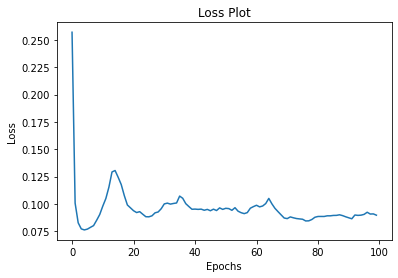

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluation


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(50, 50))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
Image.open("Data/UIT-ViIC/train_val_combined/000000579404.jpg").size

(640, 427)

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
print(image)

result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


#Test

In [ ]:
ls Data/UIT-ViIC/

checkpoint/            preprocessed_uitviic_captions_test2017.json
npy/                   test_imgs/
pickles/               train_val_combined/
pickles_resnet152/     train_val_combined.json
predict_on_test_data/  train_val_combined_OLD.json


In [ ]:
annotation_file = "Data/UIT-ViIC/preprocessed_uitviic_captions_test2017.json"
PATH = "Data/UIT-ViIC/test_imgs/"

231
<start> Người đàn_ông trẻ đang giữ bóng dưới chân . <end>


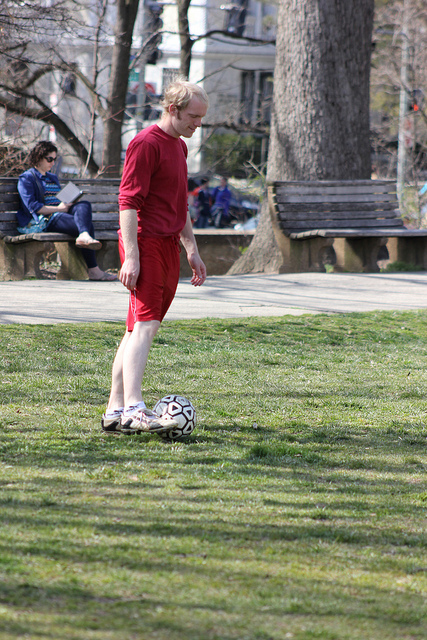

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

def preprocess_for_vietnamese(sentence):
    # cap_segment = ViTokenizer.tokenize(sentence)
    cap_segment = word_tokenize(sentence, format="text")
    return cap_segment

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  # caption = f"<start> {val['caption']} <end>"
  # print(preprocess_for_vietnamese(val['caption']))
  caption = f"<start> {preprocess_for_vietnamese(val['caption'])} <end>"
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
img_name_test = list(set(img_name_vector))
results_data = []

for index,img in enumerate(img_name_test):
    result, attention_plot = evaluate(img)
    sentence = ' '.join(result)
    sentence = sentence.replace('<start> ','')
    sentence = sentence.replace('_',' ')
    sentence = sentence.replace('<end>', '.')
    record = {
        'image_id': int(img.split("/")[-1][:-4]),
        'caption': sentence,
        'id': index
    }
    results_data.append(record)
    if index%10 == 0:
        print(f"Done image {index}/{len(img_name_test)}")

with open("result/Test_AttentionResnet152_LSTM_v6.json", 'w') as f_results:
    f_results.write(json.dumps(results_data, ensure_ascii=False))

Done image 0/3612
Done image 10/3612
Done image 20/3612


KeyboardInterrupt: ignored

In [ ]:
ls result

preprocessed_test_result_Resnet512_LSTM_pyvi.json
preprocessed_val_result_Resnet512_LSTM_pyvi.json
result_Resnet512_LSTM_1e4.json
result_Resnet512_LSTM.json
Test_AttentionResnet152_TF.json
Test_Attention_TF.json
test_result_Resnet512_LSTM_1e4.json
test_result_Resnet512_LSTM_pyvi.json
val_result_Resnet512_LSTM_pyvi.json


In [ ]:
with open("result/Test_AttentionResnet152_TF.json",'r') as f:
  test_data = json.load(f)

print(len(test_data))
print(test_data[0])

231
{'image_id': 288943, 'caption': 'hai vận động viên tennis đang cùng nhau trên sân.', 'id': 0}
